# Structured Report Generation
[![ Click here to deploy.](https://brev-assets.s3.us-west-1.amazonaws.com/nv-lb-dark.svg)](https://console.brev.dev/launchable/deploy?launchableID=env-2qzwjeLSpDcjU68lNQyDcZwxmn9)

In this notebook, you will use the newest llama model, llama-3.3-70b, to generate a report on a given topic. You will use Langchain's LangGraph to build an Agent that takes in user-defined topics and structure, then plans the topics of the section indicated in the structure. Next, the Agent uses Tavily to do web search on the given topics and uses this information to write the sections and synthesize the final report. 

Rather than deploying the model locally, you leverage NVIDIA API Catalog by calling the model's NIM API Endpoint. As you don't need a GPU to run the model, you can run this notebook anywhere!

You can find the original notebook on LangChain's GitHub [here](https://github.com/langchain-ai/report-mAIstro).

Below is the architecture diagram.

# 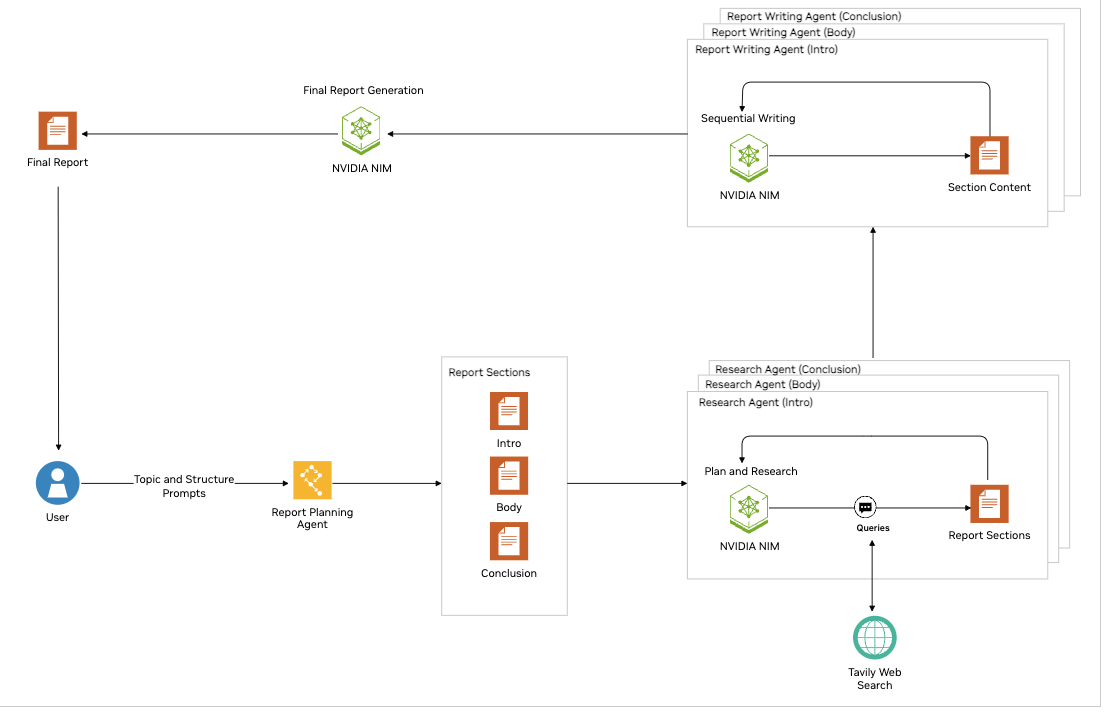


The Agent takes in user defined topics and structure, then plans the topics of the section indicated in the structure. The Agent then uses Tavily to do web search on the given topics and uses this information to write the sections and synthesize the final report. 

 
A two-phase approach is used for planning and research: 


Phase 1 - Planning 
- Analyzes user inputs 
- Maps out report sections 

 
Phase 2 - Research 
- Conducts parallel web research via Tavily API 
- Processes relevant data for each section 

 

The report is then written in a strategic sequence: 
- Write research-based sections in parallel 
- Write introductions, conclusions, and connect each of the sections  


All sections maintain awareness of each other's content for consistency. 

# Content Overview
>[Prerequisites](#Prerequisites)  
>[Writing Report Plan](#Writing-Report-Plan)  
>[Research and Writing](#Research-and-Writing)  
>[Write Single Section](#Write-Single-Section)  
>[Validate Single Section](#Validate-Single-Section)  
>[Write All Sections](#Write-All-Sections)  
>[Validate Final Report](#Final-Report)
________________________


## Prerequisites

### Install Dependencies

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_community langchain_core tavily-python langchain_nvidia_ai_endpoints

## API Keys
Prior to getting started, you will need to create API Keys for the NVIDIA API Catalog, Tavily, and LangChain.

- NVIDIA API Catalog
  1. Navigate to **[NVIDIA API Catalog](https://build.nvidia.com/explore/discover)**.
  2. Select any model, such as llama-3.3-70b-instruct.
  3. On the right panel above the sample code snippet, click on "Get API Key". This will prompt you to log in if you have not already.
- LangChain
  1. Go to **[LangChain Settings page](https://smith.langchain.com/settings)**. You will need to create an account if you have not already.
  2. On the left panel, navigate to "API Keys".
  3. Click on the "Create API Key" on the top right of the page.
- Tavily
  1. Go to the **[Tavily homepage](https://tavily.com/)** and click on "Get Started"
  2. Sign in or create an account.
  3. Create an API Key.

### Export API Keys

Save these API Keys as environment variables.

First, set the NVIDIA API Key as the environment variable.

In [ ]:
import getpass
import os

if not os.environ.get("NVIDIA_API_KEY", "").startswith("nvapi-"):
    nvapi_key = getpass.getpass("Enter your NVIDIA API key: ")
    assert nvapi_key.startswith("nvapi-"), f"{nvapi_key[:5]}... is not a valid key"
    os.environ["NVIDIA_API_KEY"] = nvapi_key

Next, set the LangChain API Key as an environment variable. You will use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [ ]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")
        
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "report-mAIstro"

Finally, set the Tavily API Key as an environment variable. You will use [Tavily API](https://tavily.com/) web search tool.

In [ ]:
_set_env("TAVILY_API_KEY")

In [ ]:
from tavily import TavilyClient, AsyncTavilyClient
tavily_client = TavilyClient()
tavily_async_client = AsyncTavilyClient()

### Working with the NVIDIA API Catalog

Let's test the API endpoint.

In this notebook, you will use the newest llama model, llama-3.3-70b-instruct, as the LLM. Define the LLM below and test the API Catalog.


In [ ]:
## Core LC Chat Interface
from langchain_nvidia_ai_endpoints import ChatNVIDIA

llm = ChatNVIDIA(model="meta/llama-3.3-70b-instruct", temperature=0)
result = llm.invoke("Write a ballad about LangChain.")
print(result.content)

### Optional: Locally Run NVIDIA NIM Microservices

Once you familiarize yourself with this blueprint, you may want to self-host models with NVIDIA NIM Microservices using NVIDIA AI Enterprise software license. This gives you the ability to run models anywhere, giving you ownership of your customizations and full control of your intellectual property (IP) and AI applications.

[Learn more about NIM Microservices](https://developer.nvidia.com/blog/nvidia-nim-offers-optimized-inference-microservices-for-deploying-ai-models-at-scale/)

<div class="alert alert-block alert-success">
<b>NOTE:</b> Run the following cell only if you're using a local NIM Microservice instead of the API Catalog Endpoint.
</div>

In [ ]:
from langchain_nvidia_ai_endpoints import ChatNVIDIA

# connect to an embedding NIM running at localhost:8000, specifying a model
llm = ChatNVIDIA(base_url="http://localhost:8000/v1", model="meta/llama3-8b-instruct")

# Writing Report Plan

## Creating Utils Functions

Next, you will create Utility functions that will be used for web research during report generation.

In [ ]:
import asyncio
from langsmith import traceable
from pydantic import BaseModel, Field

class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )
    research: bool = Field(
        description="Whether to perform web research for this section of the report."
    )
    content: str = Field(
        description="The content of the section."
    ) 

def deduplicate_and_format_sources(search_response, max_tokens_per_source, include_raw_content=True):
    """
    Takes either a single search response or list of responses from Tavily API and formats them.
    Limits the raw_content to approximately max_tokens_per_source.
    include_raw_content specifies whether to include the raw_content from Tavily in the formatted string.
    
    Args:
        search_response: Either:
            - A dict with a 'results' key containing a list of search results
            - A list of dicts, each containing search results
            
    Returns:
        str: Formatted string with deduplicated sources
    """
    # Convert input to list of results
    if isinstance(search_response, dict):
        sources_list = search_response['results']
    elif isinstance(search_response, list):
        sources_list = []
        for response in search_response:
            if isinstance(response, dict) and 'results' in response:
                sources_list.extend(response['results'])
            else:
                sources_list.extend(response)
    else:
        raise ValueError("Input must be either a dict with 'results' or a list of search results")
    
    # Deduplicate by URL
    unique_sources = {}
    for source in sources_list:
        if source['url'] not in unique_sources:
            unique_sources[source['url']] = source
    
    # Format output
    formatted_text = "Sources:\n\n"
    for i, source in enumerate(unique_sources.values(), 1):
        formatted_text += f"Source {source['title']}:\n===\n"
        formatted_text += f"URL: {source['url']}\n===\n"
        formatted_text += f"Most relevant content from source: {source['content']}\n===\n"
        if include_raw_content:
            # Using rough estimate of 4 characters per token
            char_limit = max_tokens_per_source * 4
            # Handle None raw_content
            raw_content = source.get('raw_content', '')
            if raw_content is None:
                raw_content = ''
                print(f"Warning: No raw_content found for source {source['url']}")
            if len(raw_content) > char_limit:
                raw_content = raw_content[:char_limit] + "... [truncated]"
            formatted_text += f"Full source content limited to {max_tokens_per_source} tokens: {raw_content}\n\n"
                
    return formatted_text.strip()

def format_sections(sections: list[Section]) -> str:
    """ Format a list of sections into a string """
    formatted_str = ""
    for idx, section in enumerate(sections, 1):
        formatted_str += f"""
{'='*60}
Section {idx}: {section.name}
{'='*60}
Description:
{section.description}
Requires Research: 
{section.research}

Content:
{section.content if section.content else '[Not yet written]'}

"""
    return formatted_str

@traceable
def tavily_search(query):
    """ Search the web using the Tavily API.
    
    Args:
        query (str): The search query to execute
        
    Returns:
        dict: Tavily search response containing:
            - results (list): List of search result dictionaries, each containing:
                - title (str): Title of the search result
                - url (str): URL of the search result
                - content (str): Snippet/summary of the content
                - raw_content (str): Full content of the page if available"""
     
    return tavily_client.search(query, 
                         max_results=5, 
                         include_raw_content=True)

@traceable
async def tavily_search_async(search_queries, tavily_topic, tavily_days):
    """
    Performs concurrent web searches using the Tavily API.

    Args:
        search_queries (List[SearchQuery]): List of search queries to process
        tavily_topic (str): Type of search to perform ('news' or 'general')
        tavily_days (int): Number of days to look back for news articles (only used when tavily_topic='news')

    Returns:
        List[dict]: List of search results from Tavily API, one per query

    Note:
        For news searches, each result will include articles from the last `tavily_days` days.
        For general searches, the time range is unrestricted.
    """
    
    search_tasks = []
    for query in search_queries:
        if tavily_topic == "news":
            search_tasks.append(
                tavily_async_client.search(
                    query,
                    max_results=5,
                    include_raw_content=True,
                    topic="news",
                    days=tavily_days
                )
            )
        else:
            search_tasks.append(
                tavily_async_client.search(
                    query,
                    max_results=5,
                    include_raw_content=True,
                    topic="general"
                )
            )

    # Execute all searches concurrently
    search_docs = await asyncio.gather(*search_tasks)

    return search_docs

## Planning

First, let's define the Schema for report sections.

In [ ]:
from typing_extensions import TypedDict
from typing import  Annotated, List, Optional, Literal
  
class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )
class SearchQuery(BaseModel):
    search_query: str = Field(
        None, description="Query for web search."
    )
class Queries(BaseModel):
    queries: List[SearchQuery] = Field(
        description="List of search queries.",
    )

Now you will define the LangGraph state. Each state will have the following fields. 

In [ ]:
import operator

class ReportState(TypedDict):
    topic: str # Report topic
    tavily_topic: Literal["general", "news"] # Tavily search topic
    tavily_days: Optional[int] # Only applicable for news topic
    report_structure: str # Report structure
    number_of_queries: int # Number web search queries to perform per section    
    sections: list[Section] # List of report sections 
    completed_sections: Annotated[list, operator.add] # Send() API key
    report_sections_from_research: str # String of any completed sections from research to write final sections
    final_report: str # Final report

Next you will write the report planner instructions, and a function that will generate the report sections.

In [ ]:
from langchain_core.messages import HumanMessage, SystemMessage

# Prompt to generate a search query to help with planning the report outline
report_planner_query_writer_instructions="""You are an expert technical writer, helping to plan a report. 

The report will be focused on the following topic:

{topic}

The report structure will follow these guidelines:

{report_organization}

Your goal is to generate {number_of_queries} search queries that will help gather comprehensive information for planning the report sections. 

The query should:

1. Be related to the topic 
2. Help satisfy the requirements specified in the report organization

Make the query specific enough to find high-quality, relevant sources while covering the breadth needed for the report structure."""

# Prompt generating the report outline
report_planner_instructions="""You are an expert technical writer, helping to plan a report.

Your goal is to generate the outline of the sections of the report. 

The overall topic of the report is:

{topic}

The report should follow this organization: 

{report_organization}

You should reflect on this information to plan the sections of the report: 

{context}

Now, generate the sections of the report. Each section should have the following fields:

- Name - Name for this section of the report.
- Description - Brief overview of the main topics and concepts to be covered in this section.
- Research - Whether to perform web research for this section of the report.
- Content - The content of the section, which you will leave blank for now.

Consider which sections require web research. For example, introduction and conclusion will not require research because they will distill information from other parts of the report."""

async def generate_report_plan(state: ReportState):

    # Inputs
    topic = state["topic"]
    report_structure = state["report_structure"]
    number_of_queries = state["number_of_queries"]
    tavily_topic = state["tavily_topic"]
    tavily_days = state.get("tavily_days", None)

    # Convert JSON object to string if necessary
    if isinstance(report_structure, dict):
        report_structure = str(report_structure)

    # Generate search query
    structured_llm = llm.with_structured_output(Queries)
    
    # Format system instructions
    system_instructions_query = report_planner_query_writer_instructions.format(topic=topic, report_organization=report_structure, number_of_queries=number_of_queries)
    
    # Generate queries  
    results = structured_llm.invoke([SystemMessage(content=system_instructions_query)]+[HumanMessage(content="Generate search queries that will help with planning the sections of the report.")])
    
    # Web search
    query_list = [query.search_query for query in results.queries]
    search_docs = await tavily_search_async(query_list, tavily_topic, tavily_days)

    # Deduplicate and format sources
    source_str = deduplicate_and_format_sources(search_docs, max_tokens_per_source=1000, include_raw_content=True)

    # Format system instructions
    system_instructions_sections = report_planner_instructions.format(topic=topic, report_organization=report_structure, context=source_str)

    # Generate sections 
    structured_llm = llm.with_structured_output(Sections)
    report_sections = structured_llm.invoke([SystemMessage(content=system_instructions_sections)]+[HumanMessage(content="Generate the sections of the report. Your response must include a 'sections' field containing a list of sections. Each section must have: name, description, plan, research, and content fields.")])
    
    return {"sections": report_sections.sections}

In [ ]:
# Structure
report_structure = """This report type focuses on comparative analysis.

The report structure should include:
1. Introduction (no research needed)
   - Brief overview of the topic area
   - Context for the comparison

2. Main Body Sections:
   - One dedicated section for EACH offering being compared in the user-provided list
   - Each section should examine:
     - Core Features (bulleted list)
     - Architecture & Implementation (2-3 sentences)
     - One example use case (2-3 sentences)
   
3. No Main Body Sections other than the ones dedicated to each offering in the user-provided list

4. Conclusion with Comparison Table (no research needed)
   - Structured comparison table that:
     * Compares all offerings from the user-provided list across key dimensions
     * Highlights relative strengths and weaknesses
   - Final recommendations"""

Finally, choose the topic of your report. The default is CPU vs. GPU, but feel free to change the topic to something of your interest. 

In [ ]:
# Topic 
report_topic = "Give an overview of capabilities and specific use case examples for these processing units: CPU, GPU."

Let's run the agent. We set the Tavily topic to "general", but you can set it to "news" if you want Tavily to retrieve latest searches. 

In [ ]:
# Tavily search parameters
tavily_topic = "general"
tavily_days = None # Only applicable for news topic

# Generate report plan
sections = await generate_report_plan({"topic": report_topic, "report_structure": report_structure, "number_of_queries": 2, "tavily_topic": tavily_topic, "tavily_days": tavily_days})

# Print sections
for section in sections['sections']:
    print(f"{'='*50}")
    print(f"Name: {section.name}")
    print(f"Description: {section.description}")
    print(f"Research: {section.research}")

## Research and Writing


Now you are ready to give the Agent details about which sections require research, and the number of queries needed.  Let's First you will define the LangGraph state. Each state will have the following fields. 

Let's define the LangGraph state. Each state will have the following fields:

In [ ]:
class SectionState(TypedDict):
    tavily_topic: Literal["general", "news"] # Tavily search topic
    tavily_days: Optional[int] # Only applicable for news topic
    number_of_queries: int # Number web search queries to perform per section 
    section: Section # Report section   
    search_queries: list[SearchQuery] # List of search queries
    source_str: str # String of formatted source content from web search
    report_sections_from_research: str # String of any completed sections from research to write final sections
    completed_sections: list[Section] # Final key we duplicate in outer state for Send() API

class SectionOutputState(TypedDict):
    completed_sections: list[Section] # Final key we duplicate in outer state for Send() API

### Write Single Section
Now you will define the query writer instructions and the Agent function and nodes.

In [ ]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph

# Query writer instructions
query_writer_instructions="""Your goal is to generate targeted web search queries that will gather comprehensive information for writing a technical report section.

Topic for this section:
{section_topic}

When generating {number_of_queries} search queries, ensure they:
1. Cover different aspects of the topic (e.g., core features, real-world applications, technical architecture)
2. Include specific technical terms related to the topic
3. Target recent information by including year markers where relevant (e.g., "2024")
4. Look for comparisons or differentiators from similar technologies/approaches
5. Search for both official documentation and practical implementation examples

Your queries should be:
- Specific enough to avoid generic results
- Technical enough to capture detailed implementation information
- Diverse enough to cover all aspects of the section plan
- Focused on authoritative sources (documentation, technical blogs, academic papers)"""

# Section writer instructions
section_writer_instructions = """You are an expert technical writer crafting one section of a technical report.

Topic for this section:
{section_topic}

Guidelines for writing:

1. Technical Accuracy:
- Include specific version numbers
- Reference concrete metrics/benchmarks
- Cite official documentation
- Use technical terminology precisely

2. Length and Style:
- Strict 150-200 word limit
- No marketing language
- Technical focus
- Write in simple, clear language
- Start with your most important insight in **bold**
- Use short paragraphs (2-3 sentences max)

3. Structure:
- Use ## for section title (Markdown format)
- Only use ONE structural element IF it helps clarify your point:
  * Either a focused table comparing 2-3 key items (using Markdown table syntax)
  * Or a short list (3-5 items) using proper Markdown list syntax:
    - Use `*` or `-` for unordered lists
    - Use `1.` for ordered lists
    - Ensure proper indentation and spacing
- End with ### Sources that references the below source material formatted as:
  * List each source with title, date, and URL
  * Format: `- Title : URL`

3. Writing Approach:
- Include at least one specific example or case study
- Use concrete details over general statements
- Make every word count
- No preamble prior to creating the section content
- Focus on your single most important point

4. Use this source material to help write the section:
{context}

5. Quality Checks:
- Exactly 150-200 words (excluding title and sources)
- Careful use of only ONE structural element (table or list) and only if it helps clarify your point
- One specific example / case study
- Starts with bold insight
- No preamble prior to creating the section content
- Sources cited at end"""

def generate_queries(state: SectionState):
    """ Generate search queries for a section """

    # Get state 
    number_of_queries = state["number_of_queries"]
    section = state["section"]

    # Generate queries 
    structured_llm = llm.with_structured_output(Queries)

    # Format system instructions
    system_instructions = query_writer_instructions.format(section_topic=section.description, number_of_queries=number_of_queries)

    # Generate queries  
    queries = structured_llm.invoke([SystemMessage(content=system_instructions)]+[HumanMessage(content="Generate search queries on the provided topic.")])

    return {"search_queries": queries.queries}

async def search_web(state: SectionState):
    """ Search the web for each query, then return a list of raw sources and a formatted string of sources."""
    
    # Get state 
    search_queries = state["search_queries"]
    tavily_topic = state["tavily_topic"]
    tavily_days = state.get("tavily_days", None)

    # Web search
    query_list = [query.search_query for query in search_queries]
    search_docs = await tavily_search_async(query_list, tavily_topic, tavily_days)

    # Deduplicate and format sources
    source_str = deduplicate_and_format_sources(search_docs, max_tokens_per_source=5000, include_raw_content=True)

    return {"source_str": source_str}

def write_section(state: SectionState):
    """ Write a section of the report """

    # Get state 
    section = state["section"]
    source_str = state["source_str"]

    # Format system instructions
    system_instructions = section_writer_instructions.format(section_title=section.name, section_topic=section.description, context=source_str)

    # Generate section  
    section_content = llm.invoke([SystemMessage(content=system_instructions)]+[HumanMessage(content="Generate a report section based on the provided sources.")])
    
    # Write content to the section object  
    section.content = section_content.content

    # Write the updated section to completed sections
    return {"completed_sections": [section]}

# Add nodes and edges 
section_builder = StateGraph(SectionState, output=SectionOutputState)
section_builder.add_node("generate_queries", generate_queries)
section_builder.add_node("search_web", search_web)
section_builder.add_node("write_section", write_section)

section_builder.add_edge(START, "generate_queries")
section_builder.add_edge("generate_queries", "search_web")
section_builder.add_edge("search_web", "write_section")
section_builder.add_edge("write_section", END)

# Compile
section_builder_graph = section_builder.compile()

# View
display(Image(section_builder_graph.get_graph(xray=1).draw_mermaid_png()))

### Validate Single Section

Call on the Agent to write a single section to ensure the content is generated as expected. 

In [ ]:
# Test with one section
sections = sections['sections'] 
test_section = sections[1]
print(f"{'='*50}")
print(f"Name: {test_section.name}")
print(f"Description: {test_section.description}")
print(f"Research: {test_section.research}")

# Run
report_section = await section_builder_graph.ainvoke({"section": test_section, "number_of_queries": 2, "tavily_topic": tavily_topic, "tavily_days": tavily_days})

In [ ]:
from IPython.display import Markdown
section = report_section['completed_sections'][0]
Markdown(section.content)

### Write All Sections

In [ ]:
class ReportStateOutput(TypedDict):
    final_report: str # Final report

In [ ]:
from langgraph.constants import Send

final_section_writer_instructions="""You are an expert technical writer crafting a section that synthesizes information from the rest of the report.

Section to write: 
{section_topic}

Available report content:
{context}

1. Section-Specific Approach:

For Introduction:
- Use # for report title (Markdown format)
- 50-100 word limit
- Write in simple and clear language
- Focus on the core motivation for the report in 1-2 paragraphs
- Use a clear narrative arc to introduce the report
- Include NO structural elements (no lists or tables)
- No sources section needed

For Conclusion/Summary:
- Use ## for section title (Markdown format)
- 100-150 word limit
- For comparative reports:
    * Must include a focused comparison table using Markdown table syntax
    * Table should distill insights from the report
    * Keep table entries clear and concise
- For non-comparative reports: 
    * Only use ONE structural element IF it helps distill the points made in the report:
    * Either a focused table comparing items present in the report (using Markdown table syntax)
    * Or a short list using proper Markdown list syntax:
      - Use `*` or `-` for unordered lists
      - Use `1.` for ordered lists
      - Ensure proper indentation and spacing
- End with specific next steps or implications
- No sources section needed

3. Writing Approach:
- Use concrete details over general statements
- Make every word count
- Focus on your single most important point

4. Quality Checks:
- For introduction: 50-100 word limit, # for report title, no structural elements, no sources section
- For conclusion: 100-150 word limit, ## for section title, only ONE structural element at most, no sources section
- Markdown format
- Do not include word count or any preamble in your response"""

def initiate_section_writing(state: ReportState):
    """ This is the "map" step when we kick off web research for some sections of the report """    
    
    # Kick off section writing in parallel via Send() API for any sections that require research
    return [
        Send("build_section_with_web_research", {"section": s, 
                                                 "number_of_queries": state["number_of_queries"], 
                                                 "tavily_topic": state["tavily_topic"], 
                                                 "tavily_days": state.get("tavily_days", None)}) 
        for s in state["sections"] 
        if s.research
    ]

def write_final_sections(state: SectionState):
    """ Write final sections of the report, which do not require web search and use the completed sections as context """

    # Get state 
    section = state["section"]
    completed_report_sections = state["report_sections_from_research"]
    
    # Format system instructions
    system_instructions = final_section_writer_instructions.format(section_title=section.name, section_topic=section.description, context=completed_report_sections)

    # Generate section  
    section_content = llm.invoke([SystemMessage(content=system_instructions)]+[HumanMessage(content="Generate a report section based on the provided sources.")])
    
    # Write content to section 
    section.content = section_content.content

    # Write the updated section to completed sections
    return {"completed_sections": [section]}

def gather_completed_sections(state: ReportState):
    """ Gather completed sections from research """    

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = format_sections(completed_sections)

    return {"report_sections_from_research": completed_report_sections}

def initiate_final_section_writing(state: ReportState):
    """ This is the "map" step when we kick off research on any sections that require it using the Send API """    

    # Kick off section writing in parallel via Send() API for any sections that do not require research
    return [
        Send("write_final_sections", {"section": s, "report_sections_from_research": state["report_sections_from_research"]}) 
        for s in state["sections"] 
        if not s.research
    ]

def compile_final_report(state: ReportState):
    """ Compile the final report """    

    # Get sections
    sections = state["sections"]
    completed_sections = {s.name: s.content for s in state["completed_sections"]}

    # Update sections with completed content while maintaining original order
    for section in sections:
        section.content = completed_sections[section.name]

    # Compile final report
    all_sections = "\n\n".join([s.content for s in sections])

    return {"final_report": all_sections}

# Add nodes and edges 
builder = StateGraph(ReportState, output=ReportStateOutput)
builder.add_node("generate_report_plan", generate_report_plan)
builder.add_node("build_section_with_web_research", section_builder.compile())
builder.add_node("gather_completed_sections", gather_completed_sections)
builder.add_node("write_final_sections", write_final_sections)
builder.add_node("compile_final_report", compile_final_report)
builder.add_edge(START, "generate_report_plan")
builder.add_conditional_edges("generate_report_plan", initiate_section_writing, ["build_section_with_web_research"])
builder.add_edge("build_section_with_web_research", "gather_completed_sections")
builder.add_conditional_edges("gather_completed_sections", initiate_final_section_writing, ["write_final_sections"])
builder.add_edge("write_final_sections", "compile_final_report")
builder.add_edge("compile_final_report", END)

graph = builder.compile()
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [ ]:
# Structure
report_structure = """This report type focuses on comparative analysis.

The report structure should include:
1. Introduction (no research needed)
   - Brief overview of the topic area
   - Context for the comparison

2. Main Body Sections:
   - One dedicated section for EACH offering being compared in the user-provided list
   - Each section should examine:
     - Core Features (bulleted list)
     - Architecture & Implementation (2-3 sentences)
     - One example use case (2-3 sentences)
   
3. No Main Body Sections other than the ones dedicated to each offering in the user-provided list

4. Conclusion with Comparison Table (no research needed)
   - Structured comparison table that:
     * Compares all offerings from the user-provided list across key dimensions
     * Highlights relative strengths and weaknesses
   - Final recommendations"""

# Tavily search parameters
tavily_topic = "general"
tavily_days = None # Only applicable for news topic

Once again, choose the topic of your report. The default is CPU vs. GPU, but feel free to change the topic to something of your interest. 

In [ ]:
# Topic 
report_topic = "Give an overview of capabilities and specific use case examples for these processing units: CPU, GPU."

In [ ]:
report = await graph.ainvoke({"topic": report_topic, 
                                   "report_structure": report_structure, 
                                   "number_of_queries": 2, 
                                   "tavily_topic": tavily_topic, 
                                   "tavily_days": tavily_days})

# Final Report
Let's validate all sections. This is the final report the Agent has written. 
Finally, let's look at the final output. 

In [ ]:
from IPython.display import Markdown
Markdown(report['final_report'])

In [ ]:
#print the final report in plain text
report['final_report']